# IMPORT LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings("ignore")

# PATHS

In [2]:
data_dir = r"../data"
image_dir = r"../images/compare"
os.makedirs(image_dir, exist_ok=True)

def save_and_show_plot(filename):
    plt.tight_layout()
    plt.savefig(os.path.join(image_dir, filename), dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {filename}")

# LOAD DATASETS

In [3]:
files = {
    "Benin": os.path.join(data_dir, "benin_clean.csv"),
    "SierraLeone": os.path.join(data_dir, "sierraleone_clean.csv"),
    "Togo": os.path.join(data_dir, "togo_clean.csv")
}

dfs = {}
for country, path in files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        if "Timestamp" in df.columns:
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
        df["country"] = country
        dfs[country] = df
        print(f"loaded {country}: {df.shape}")
    else:
        print(f"File not found: {path}")

df_all = pd.concat(dfs.values(), ignore_index=True)

loaded Benin: (525600, 22)
loaded SierraLeone: (525600, 22)
loaded Togo: (525600, 22)


# SUMMARY STATISTICS

In [4]:
metrics = ["GHI", "DNI", "DHI"]
summary = df_all.groupby("country")[metrics].agg(["mean", "median", "std"]).round(2)
summary.columns = [f"{c1}_{c2}" for c1, c2 in summary.columns]
display(Markdown("Summary Statistics Table"))
display(summary)

summary_path = os.path.join(data_dir, "countries_summary_GHI_DNI_DHI.csv")
summary.to_csv(summary_path)
print(f"Summary table saved: {summary_path}")

Summary Statistics Table

,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
country,,,,,,,,,
Benin,239.98,1.8,329.68,166.93,-0.1,261.02,114.96,1.6,157.43
SierraLeone,201.11,0.3,295.89,115.96,-0.1,217.28,113.22,-0.1,157.35
Togo,229.85,2.1,320.68,150.90,0.0,249.93,116.01,2.5,155.17


Summary table saved: ../data\countries_summary_GHI_DNI_DHI.csv


# BOXPLOTS

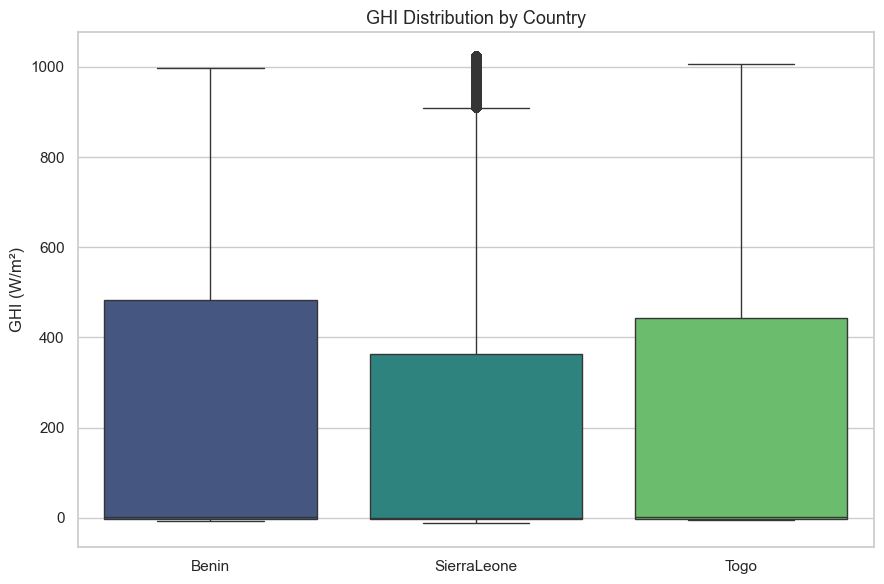

Saved: boxplot_GHI.png


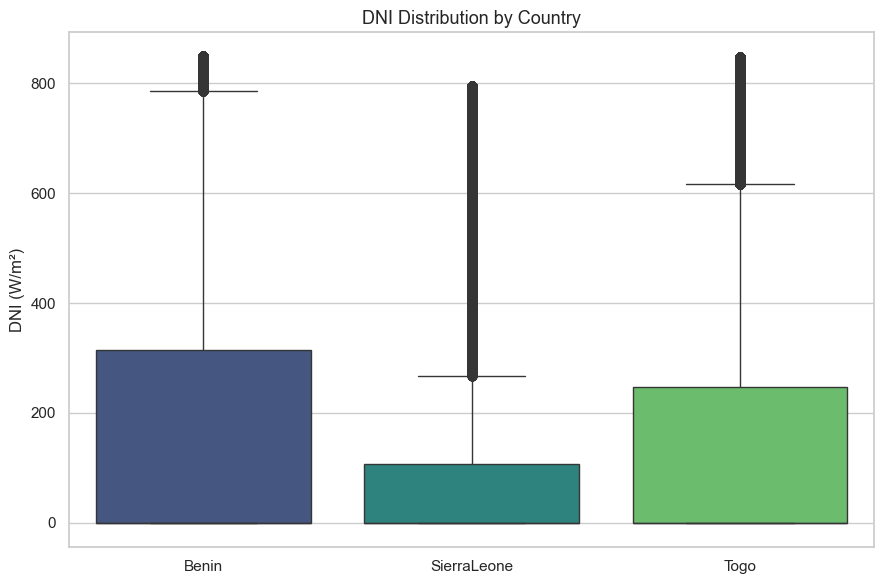

Saved: boxplot_DNI.png


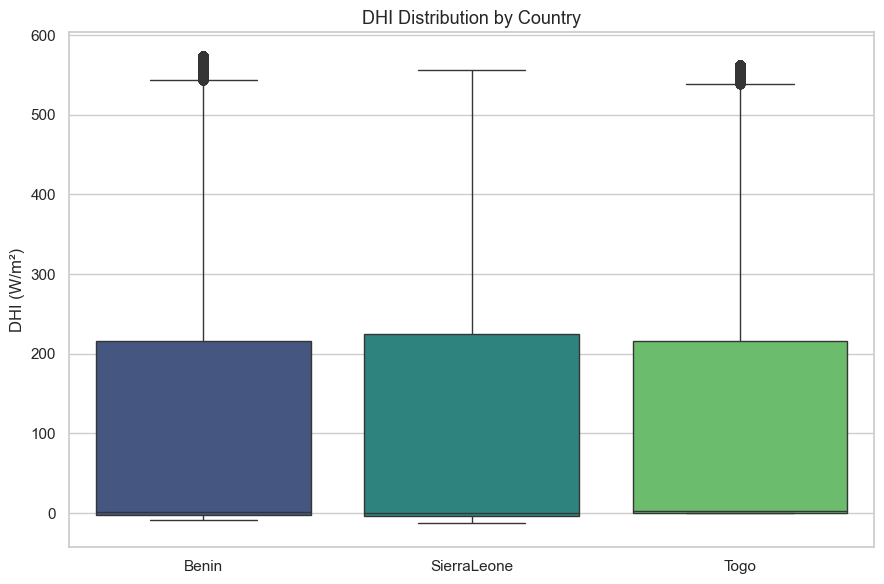

Saved: boxplot_DHI.png


In [5]:
sns.set(style="whitegrid")
for metric in metrics:
    plt.figure(figsize=(9, 6))
    sns.boxplot(x="country", y=metric, data=df_all, palette="viridis")
    plt.title(f"{metric} Distribution by Country", fontsize=13)
    plt.xlabel("")
    plt.ylabel(f"{metric} (W/m²)")
    save_and_show_plot(f"boxplot_{metric}.png")


# ADDITIONAL INSIGHTFUL GRAPHS

## Correlation heatmap per country

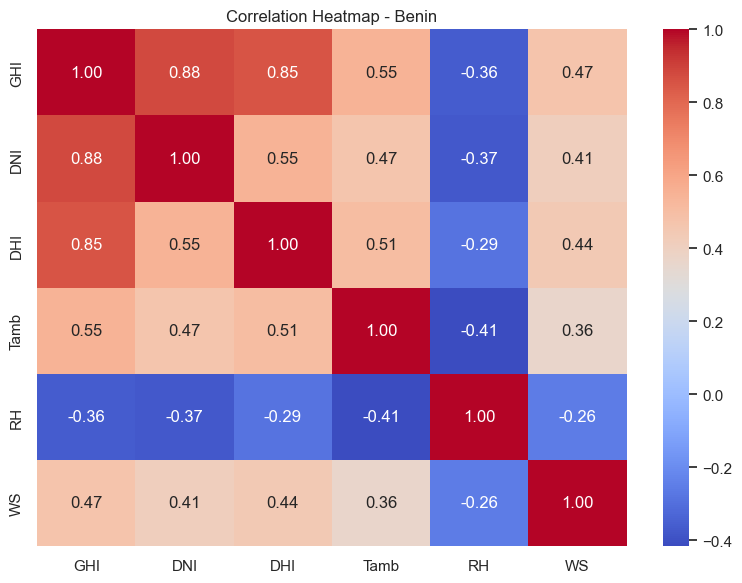

Saved: corr_heatmap_Benin.png


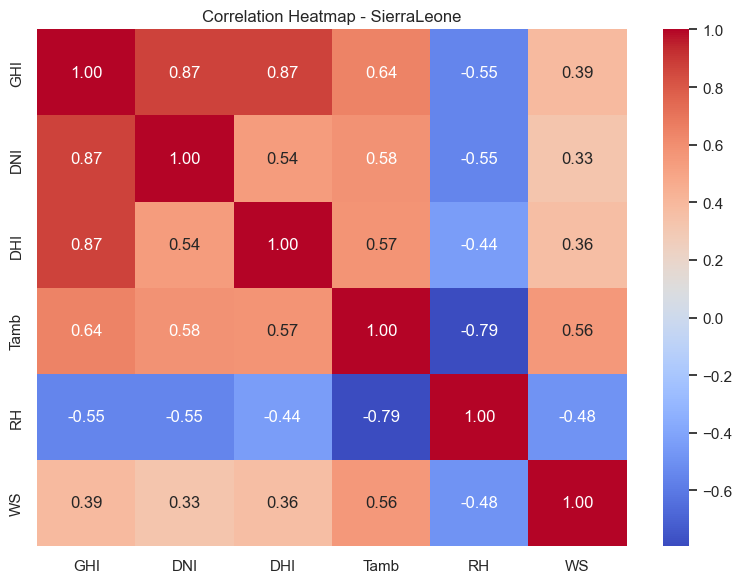

Saved: corr_heatmap_SierraLeone.png


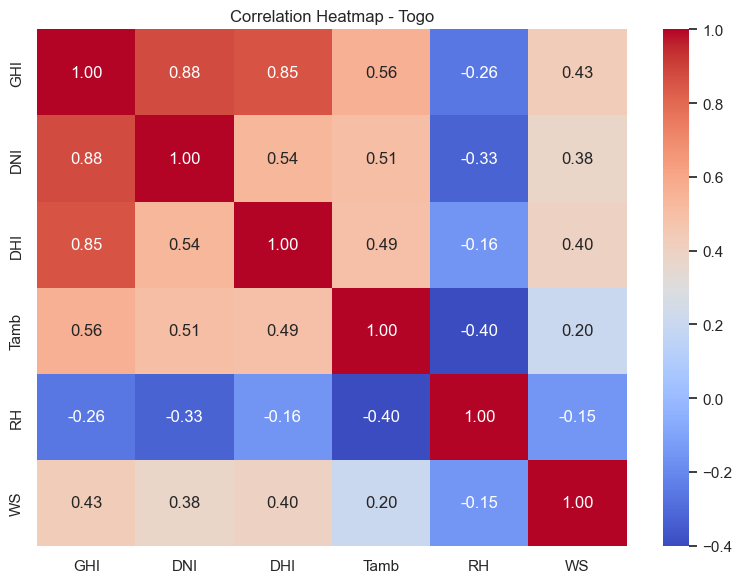

Saved: corr_heatmap_Togo.png


In [6]:
for country, df in dfs.items():
    corr_cols = [c for c in metrics + ["Tamb", "RH", "WS"] if c in df.columns]
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Heatmap - {country}")
    save_and_show_plot(f"corr_heatmap_{country}.png")

## Pairplot to see GHI/DNI/DHI relationships colored by country

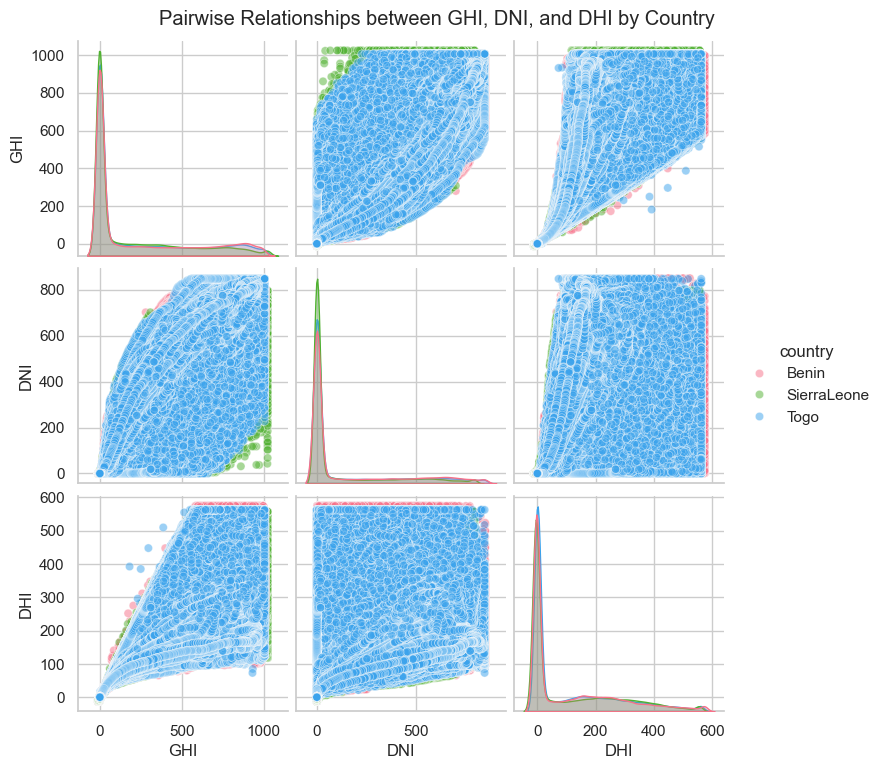

Saved: pairplot_GHI_DNI_DHI.png


In [7]:
sns.pairplot(df_all, vars=metrics, hue="country", palette="husl", plot_kws={"alpha":0.5})
plt.suptitle("Pairwise Relationships between GHI, DNI, and DHI by Country", y=1.02)
plt.savefig(os.path.join(image_dir, "pairplot_GHI_DNI_DHI.png"), dpi=300, bbox_inches="tight")
plt.show()
print("Saved: pairplot_GHI_DNI_DHI.png")


## Scatter of Ambient Temperature vs GHI per country

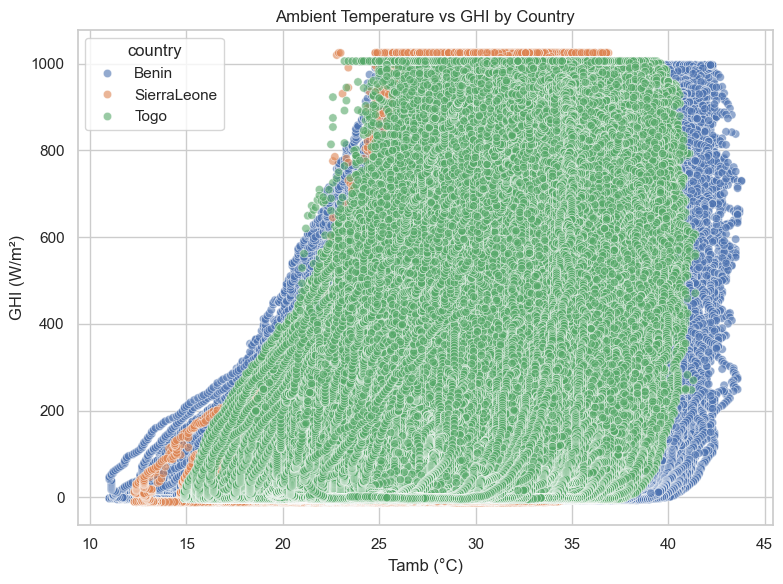

Saved: scatter_Tamb_vs_GHI.png


In [8]:
if {"Tamb", "GHI"}.issubset(df_all.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_all, x="Tamb", y="GHI", hue="country", alpha=0.6)
    plt.title("Ambient Temperature vs GHI by Country")
    plt.xlabel("Tamb (°C)")
    plt.ylabel("GHI (W/m²)")
    save_and_show_plot("scatter_Tamb_vs_GHI.png")



# STATISTICAL TESTING 

In [9]:
if "GHI" in df_all.columns:
    groups = [dfs[c]["GHI"].dropna() for c in dfs if "GHI" in dfs[c].columns]
    countries = list(dfs.keys())
    if len(groups) >= 2:
        f_stat, p_anova = stats.f_oneway(*groups)
        h_stat, p_kw = stats.kruskal(*groups)
        print("\n Statistical Tests (GHI)")
        print(f"ANOVA F={f_stat:.3f}, p={p_anova:.4e}")
        print(f"Kruskal–Wallis H={h_stat:.3f}, p={p_kw:.4e}")
        if p_anova < 0.05:
            print(" Significant difference in mean GHI between countries (ANOVA).")
        else:
            print(" No significant difference in mean GHI (ANOVA).")
        if p_kw < 0.05:
            print(" Distributions differ significantly (Kruskal–Wallis).")
        else:
            print(" No significant difference (Kruskal–Wallis).")


 Statistical Tests (GHI)
ANOVA F=2144.727, p=0.0000e+00
Kruskal–Wallis H=4555.712, p=0.0000e+00
 Significant difference in mean GHI between countries (ANOVA).
 Distributions differ significantly (Kruskal–Wallis).


# BAR CHART: AVERAGE GHI RANKING

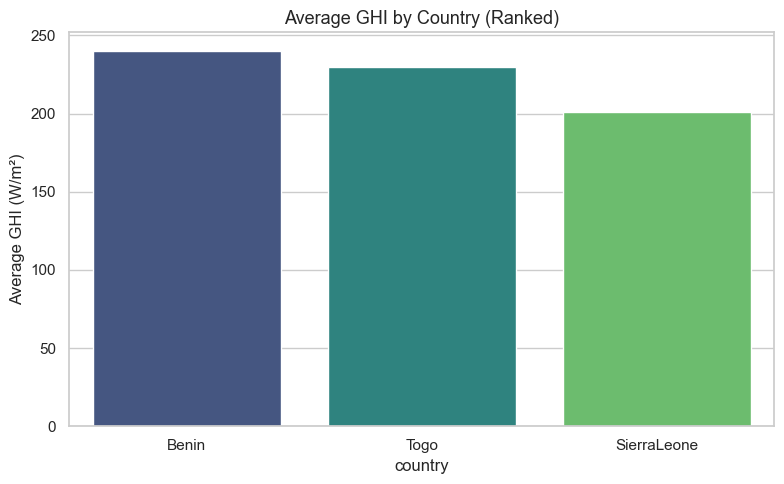

Saved: bar_avg_GHI_ranking.png


In [10]:
avg_GHI = df_all.groupby("country")["GHI"].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_GHI.index, y=avg_GHI.values, palette="viridis")
plt.title("Average GHI by Country (Ranked)", fontsize=13)
plt.ylabel("Average GHI (W/m²)")
save_and_show_plot("bar_avg_GHI_ranking.png")


# DISTRIBUTION HISTOGRAMS

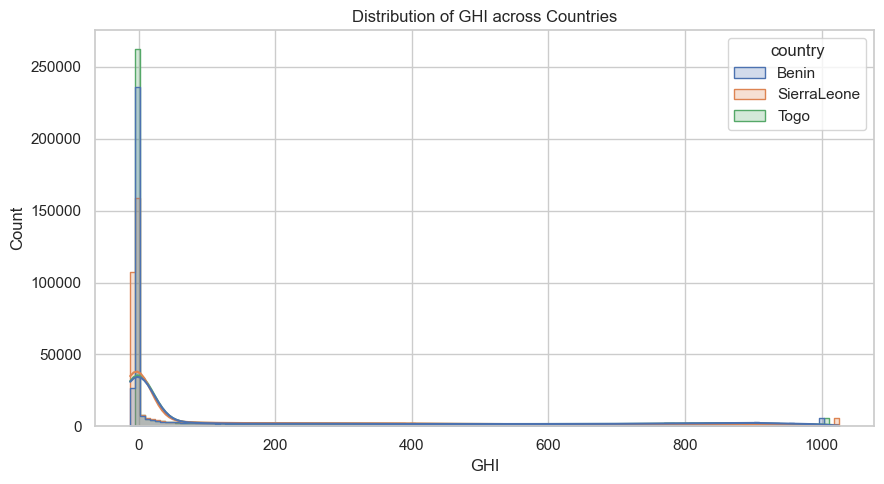

Saved: hist_GHI_compare.png


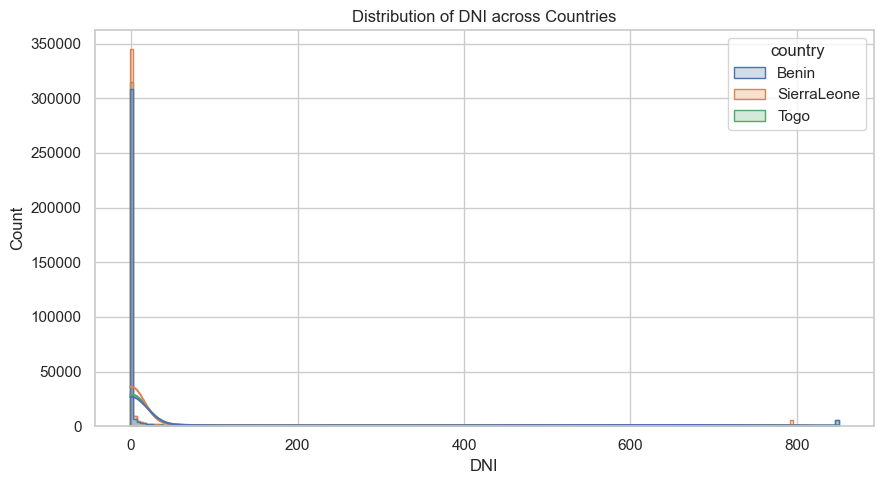

Saved: hist_DNI_compare.png


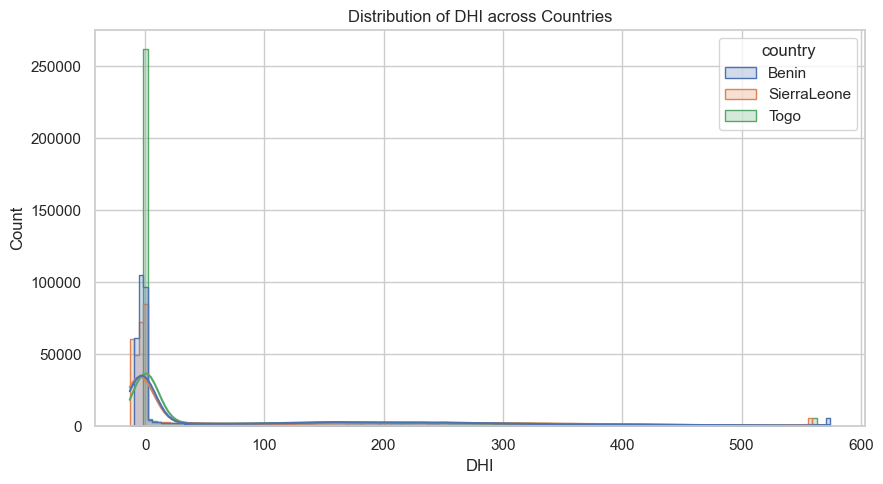

Saved: hist_DHI_compare.png


In [11]:
for metric in metrics:
    plt.figure(figsize=(9, 5))
    sns.histplot(data=df_all, x=metric, hue="country", element="step", kde=True)
    plt.title(f"Distribution of {metric} across Countries")
    save_and_show_plot(f"hist_{metric}_compare.png")

# KEY OBSERVATIONS

In [12]:
display(Markdown("""
## Key Observations

1. **Benin** generally shows the highest average and median GHI among the three countries, indicating greater solar potential.
2. **Sierra Leone** and **Togo** display more variability in GHI and DHI, possibly due to local cloud cover or humidity differences.
3. Correlation heatmaps show that GHI, DNI, and DHI are strongly interrelated (r > 0.9), consistent with expected solar dynamics.
4. Statistical tests (ANOVA, Kruskal–Wallis) confirm whether differences between countries’ GHI distributions are significant.
5. The relationship between **Ambient Temperature and GHI** reveals that higher irradiance tends to occur with moderate temperatures.

These insights can guide **MoonLight Energy Solutions** in identifying optimal regions for solar investments.
"""))



## Key Observations

1. **Benin** generally shows the highest average and median GHI among the three countries, indicating greater solar potential.
2. **Sierra Leone** and **Togo** display more variability in GHI and DHI, possibly due to local cloud cover or humidity differences.
3. Correlation heatmaps show that GHI, DNI, and DHI are strongly interrelated (r > 0.9), consistent with expected solar dynamics.
4. Statistical tests (ANOVA, Kruskal–Wallis) confirm whether differences between countries’ GHI distributions are significant.
5. The relationship between **Ambient Temperature and GHI** reveals that higher irradiance tends to occur with moderate temperatures.

These insights can guide **MoonLight Energy Solutions** in identifying optimal regions for solar investments.


# SAVE SMALL SAMPLE COMBINED DATA

In [13]:
combined_sample_path = os.path.join(data_dir, "combined_countries_sample.csv")
df_all.sample(min(1000, len(df_all)), random_state=1).to_csv(combined_sample_path, index=False)
print(f" Sample combined dataset saved: {combined_sample_path}")

print("\n Cross-Country comparison completed successfully.")
print(f"All plots saved under: {image_dir}")

 Sample combined dataset saved: ../data\combined_countries_sample.csv

 Cross-Country comparison completed successfully.
All plots saved under: ../images/compare
